In [1]:
#%load_ext autotime
import hanford.paths
import yaml
import os
import copy
import numpy as np
import numpy.random as npr
import scipy.optimize as spo
import scipy.linalg as spl
from matplotlib import pyplot as plt, path as mpath, collections as mc, patches as mpatches, cm, ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sdfs.geom_mrst import GeomMRST
from sdfs.bc_mrst import BCMRST
from sdfs.darcy import DarcyExp
from sdfs.tpfa import TPFA
from sdfs.dasa import DASAExpLM, DASAExpLMWithFlux, DASAExpLMScalar
from time import perf_counter
import ckli.mapest as mapest
import ckli.ckliest_testing as ckliest
import h5py
import hdf5storage
import GPy

In [2]:
plt.rc('text', usetex=True)
plt.rc('image', cmap='plasma')

def plot_patch(patches, values, fig, ax, points, title, cmin=None, cmax=None, cb=False):
    p = mc.PatchCollection(patches, cmap=cm.jet)
    p.set_array(values)
    p.set_clim([cmin, cmax])
    ax.add_collection(p)
    if points is not None:
        ax.plot(*points, 'ko', markersize=0.5)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.autoscale(tight=True)
    #ax.set_title(title)
    if cb:
        fig.colorbar(p, ax=ax)
    return p

In [3]:
# Parameters
resolution = '1x'
geom_filename = f'hanford_data/geom_{resolution}.mat'
bc_filename = f'hanford_data/bc_{resolution}.mat'
conduct_filename = f'hanford_data/conduct_log_{resolution}.mat'
well_cells_filename = f'hanford_data/well_cells_{resolution}.mat'
ev_gpr_filename = 'hanford_data/eigenvalues_gpr.npy'
num_trials = 1
seed = 0
NYobs = 100
NYlearn = NYobs
NYrefobs = 50
NYxi = 1000
Nens = 100000
std_dev_ref = 1.0
cor_len_ref = 0.1
conditional = False
yobs_filename = f'hanford_data/yobs_{NYobs}_{resolution}.npy'
ref = f"Yref=gpml_{NYrefobs}_{resolution}"

In [4]:
Yfac = 7.0 # Rescaling factor for log-conductivity. Must be applied to Yref and the BCs

geom = GeomMRST(geom_filename)
bc = BCMRST(geom, bc_filename)
bc.rescale('N', Yfac)
prob = DarcyExp(TPFA(geom, bc), None)

Nc = geom.cells.num
Ninf = geom.faces.num_interior
print(f'Ninf = {Ninf}, Nc = {Nc}')

Ninf = 2766, Nc = 1475


In [5]:
patches = [mpatches.Polygon(v, closed=True) for v in geom.nodes.coords.T[geom.cells.nodes.T, :]]

In [6]:
# Observations
rs = npr.RandomState(seed)

# Read stochastic model from GPML output
with h5py.File(f'hanford/gpml/hanford_david_{NYrefobs}_{resolution}.mat', 'r') as f:
    Yref = f.get('mu')[:].ravel() - Yfac
    CYpred = f.get('Kp')[:]
    xrefYobs = f.get('xYobs')[:]

uref = prob.solve(Yref)

# u observations
with h5py.File(well_cells_filename, 'r') as f:
    iuobs = f.get('well_cells')[:].ravel() - 1
uobs = uref[iuobs]
Nuobs = iuobs.size

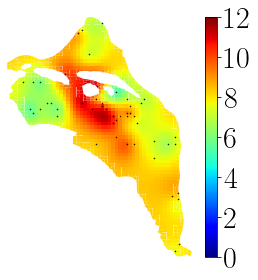

In [7]:
fig, ax = plt.subplots(figsize=(4, 4))
p = plot_patch(patches, Yref + Yfac, fig, ax, xrefYobs, 'Yref', 0, 12)
cbar = fig.colorbar(p, ax=ax)
cbar.ax.tick_params(labelsize='30')
cbar.locator = ticker.MaxNLocator(nbins=7)
cbar.update_ticks()
fig.tight_layout()
fig.savefig(f'hanford/figures/Yref/Yref_{ref}.pdf', dpi=300)

In [8]:
rl2e = lambda yest, yref : spl.norm(yest - yref, 2) / spl.norm(yref, 2)
infe = lambda yest, yref : spl.norm(yest - yref, np.inf)

In [9]:
if os.path.exists(yobs_filename):
    print(f"iYobs set read from file {yobs_filename}")
    iYobs = np.load(yobs_filename)
else:
    print(f"iYobs set randomly generated and saved to {yobs_filename}")
    iYobs = np.array([np.sort(rs.choice(Nc, NYobs, replace=False)) for _ in range(num_trials)])
    np.save(yobs_filename, iYobs)
print(f"{iYobs.shape=}")
print(iYobs)

iYobs set read from file hanford_data/yobs_100_1x.npy
iYobs.shape=(10, 100)
[[   4   14   31   34   52   53   54   82   89  122  141  142  148  152
   187  191  192  218  231  254  260  278  302  315  322  326  333  342
   347  361  362  364  376  408  420  427  431  434  438  446  458  465
   481  483  487  529  535  536  554  558  587  597  620  651  667  674
   737  758  761  838  847  853  857  863  884  897  900  930  942  961
  1001 1003 1030 1031 1054 1061 1069 1081 1095 1114 1122 1126 1131 1157
  1164 1175 1178 1187 1239 1270 1280 1285 1305 1338 1347 1352 1402 1438
  1444 1465]
 [  22   33   56   60   71   92  104  117  118  138  146  181  183  213
   216  227  246  248  276  302  306  311  329  333  336  352  378  388
   396  406  410  418  436  454  495  496  499  509  533  537  542  543
   545  547  548  600  611  615  641  643  648  668  673  678  681  692
   695  701  719  760  783  786  787  800  802  806  840  841  872  885
   906  918  933  954  961  965  968  998  999 

In [10]:
exp = f'NY={NYobs}_Nu={iuobs.size}_{NYlearn=}_{NYxi=}_{Nens=}_ba_{conditional=}_{ref}'
print(exp)

NY=100_Nu=323_NYlearn=100_NYxi=1000_Nens=100000_ba_conditional=False_Yref=gpml_50_1x


In [11]:
timings = np.zeros((num_trials, 6))
nfevs = np.zeros((num_trials, 3), dtype=int)
rel_errors = np.zeros((num_trials, 4))
abs_errors = np.zeros((num_trials, 4))

Yobs = np.zeros((num_trials, NYobs))
Ypred = np.zeros((num_trials, Nc))
CYpred = np.zeros((num_trials, Nc, Nc))
uens = np.zeros((num_trials, Nens, Nc))

PsiY = np.zeros((num_trials, Nc, NYxi))
LambdaY = np.zeros((num_trials, NYxi))
XiY = rs.randn(num_trials, Nens, NYxi)

In [12]:
for t in range(num_trials):
    iYlearn = iYobs[t]
    Ylearn = Yref[iYlearn]
    Yobs[t] = Yref[iYobs[t]]

    ts = perf_counter()
    klearn = GPy.kern.sde_Matern52(input_dim=2, variance=std_dev_ref**2, lengthscale=cor_len_ref)
    if conditional:
        mYlearn = GPy.models.GPRegression(geom.cells.centroids[:, iYlearn].T, Ylearn[:,None], klearn, noise_var=np.sqrt(np.finfo(float).eps))
        mYlearn.optimize(messages=True, ipython_notebook=False)
        print(f"{klearn.lengthscale.values[0]=}")
        print(f"{np.sqrt(klearn.variance.values[0])=}")

        mYref = GPy.models.GPRegression(geom.cells.centroids[:, iYobs[t]].T, Yobs[t,:, None], mYlearn.kern, noise_var=np.sqrt(np.finfo(float).eps))
        Ypred[t], CYpred[t] = (lambda x, y : (x.ravel(), y))(*mYref.predict_noiseless(geom.cells.centroids.T, full_cov=True))
    else:
        CYpred[t] = klearn.K(geom.cells.centroids.T)
    timings[t, 0] = perf_counter() - ts

print(f"GPR: {timings[:, 0]} s")

GPR: [0.10254553] s


In [13]:
for t in range(num_trials):
    ts = perf_counter()
    PsiY[t], LambdaY[t] = ckliest.KL_via_eigh(CYpred[t], NYxi)
    timings[t, 1] = perf_counter() - ts

print(f"eigendecomposition: {timings[:, 1]} s")

eigendecomposition: [1.61894012] s


In [14]:
for t in range(num_trials):
    # Compute GP model for u
    ts = perf_counter()
    uens[t] = ckliest.smc_ba(PsiY[t], XiY[t], Nens, copy.deepcopy(prob))
    timings[t, 2] = perf_counter() - ts

print(f"Monte Carlo: {timings[:, 2]} s")

Monte Carlo: [395.96636417] s


In [15]:
hdf5storage.savemat(f'hanford_data/XiY_PsiY_u_{exp}.mat', {'XiY': XiY, 'PsiY': PsiY, 'u': uens}, format='7.3', store_python_metadata=True)

 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/hdf5storage/__init__.py:1306: H5pyDeprecationWarning:The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
